# Darts CPI
## Juan Riofrio, Saba Infante

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy
from scipy import stats
#from filterpy.monte_carlo import systematic_resample
import darts

from darts.utils.utils import (
    SeasonalityMode, 
    TrendMode, 
    ModelMode
)

np.random.seed(1993)

In [2]:
#Errors
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))/np.abs(actual))  # MAPE
    me = np.mean(list(np.array(forecast) - np.array(actual)))             # ME
    mae = np.mean(np.abs(list(np.array(forecast) - np.array(actual))))    # MAE
    mpe = np.mean((list(np.array(forecast) - np.array(actual)))/np.array(actual))   # MPE
    rmse = np.mean(list(np.array(list(np.array(forecast) - np.array(actual)))**2))**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'corr':corr})

In [3]:
cpi_serie = pd.read_csv(r"..\Datos\cpi_ec.csv",index_col=0)

In [4]:
cpi_serie.columns = ['cpi']
#cpi_serie = cpi_serie[:-11]

In [5]:
cpi_serie.index = pd.DatetimeIndex(cpi_serie.index)

In [6]:
t_num = 12
v_num = 5

In [7]:
cpi = darts.TimeSeries.from_dataframe(cpi_serie)
train, test, val = cpi[:-(t_num+v_num)], cpi[-(t_num+v_num):-v_num],cpi[-v_num:]

In [8]:
score_df = pd.read_csv(r'..\Datos\results.csv', index_col=0)
sc_ind = list(score_df.index)

In [9]:
from darts.models import KalmanForecaster

error = float('inf')
for i in range(1,10):
    model = KalmanForecaster(dim_x=i)
    model.fit(series=train)
    p = model.predict(t_num+v_num).pd_dataframe().reset_index()
    x = forecast_accuracy(p['cpi'][:-v_num].values, list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))['mape']
    if x<error:
        error = x
        best, b_error = i, x

print(best,b_error)
model = KalmanForecaster(dim_x=1)
model.fit(series=train)
p = model.predict(t_num+v_num).pd_dataframe().reset_index()

xt = forecast_accuracy(p['cpi'][:-v_num].values, list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))
print(xt)
xv = forecast_accuracy(p['cpi'][-v_num:].values, list(cpi_serie['cpi'][-v_num:]))
print(xv)

score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('KFF')

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1 0.010814622458801784
{'mape': 0.010814622458801784, 'me': -1.1820732980644924, 'mae': 1.1820732980644924, 'mpe': -0.010814622458801784, 'rmse': 1.2676347186040557, 'corr': 0.961847521184236}
{'mape': 0.007991630258540697, 'me': -0.883069602805503, 'mae': 0.883069602805503, 'mpe': -0.007991630258540697, 'rmse': 0.8994030485952401, 'corr': 0.9558942212345748}


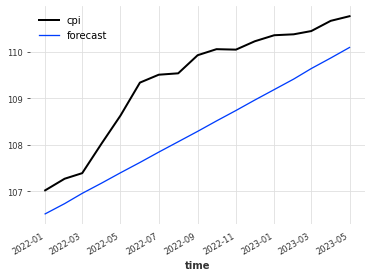

In [10]:
cpi[-(t_num+v_num):].plot()
plt.plot(p['time'],p['cpi'],label="forecast")
plt.legend()

In [11]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train)
p = model_aarima.predict(t_num+v_num)

xt = forecast_accuracy([i[0] for i in p['cpi'].values()][:-v_num], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))
print(xt)
xv = forecast_accuracy([i[0] for i in p['cpi'].values()][-v_num:], list(cpi_serie['cpi'][-v_num:]))
print(xv)

score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('AutoARIMA')

{'mape': 0.019733725071704938, 'me': -2.1585383866894667, 'mae': 2.1585383866894667, 'mpe': -0.019733725071704938, 'rmse': 2.3368699712058634, 'corr': 0.9625625882456081}
{'mape': 0.02821458807813241, 'me': -3.118529319034798, 'mae': 3.118529319034798, 'mpe': -0.02821458807813241, 'rmse': 3.1192889321017865, 'corr': 0.955619080166114}


In [12]:
from darts.models import ARIMA


model = ARIMA(p=1, d=2, q=1, seasonal_order=(4,2,4,3) ,trend=None)
model.fit(train)
p = model.predict(t_num+v_num)

xt = forecast_accuracy([i[0] for i in p['cpi'].values()][:-v_num], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))
print(xt)
xv = forecast_accuracy([i[0] for i in p['cpi'].values()][-v_num:], list(cpi_serie['cpi'][-v_num:]))
print(xv)

score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('SARIMA')

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


{'mape': 0.002395015604991575, 'me': -0.1259110341248224, 'mae': 0.2617906812895079, 'mpe': -0.0011458171875621582, 'rmse': 0.3541151171268715, 'corr': 0.957465083108454}
{'mape': 0.014525613088484633, 'me': 1.6063602191061677, 'mae': 1.6063602191061677, 'mpe': 0.014525613088484633, 'rmse': 1.72467935849743, 'corr': 0.9819403279158442}


C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
from darts.models import ExponentialSmoothing
error = float('inf')
for t in [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE]:
    for s in [SeasonalityMode.ADDITIVE,SeasonalityMode.MULTIPLICATIVE]:
        for d in [True,False]:
            for sp in [None,3,4,6,12]:
                model = ExponentialSmoothing(trend=t, damped=d,
                                             seasonal=s,
                                             seasonal_periods=sp)
                model.fit(train)
                p = model.predict(t_num)
                x = forecast_accuracy([i[0] for i in p['cpi'].values()], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))['mape']
                if x<error:
                    error = x
                    best, b_error = [t,d,s,sp], x

print(best)
model = ExponentialSmoothing(trend=best[0], damped=best[1],
                             seasonal=best[2],
                             seasonal_periods=best[3])
model.fit(train)
p = model.predict(t_num+v_num)

xt = forecast_accuracy([i[0] for i in p['cpi'].values()][:-v_num], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))
print(xt)
xv = forecast_accuracy([i[0] for i in p['cpi'].values()][-v_num:], list(cpi_serie['cpi'][-v_num:]))
print(xv)
score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('ES')

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


[<ModelMode.MULTIPLICATIVE: 'multiplicative'>, True, <SeasonalityMode.ADDITIVE: 'additive'>, 3]
{'mape': 0.006573641728781784, 'me': 0.687898617633189, 'mae': 0.72118245707822, 'mpe': 0.006263014868742883, 'rmse': 1.0032413462801972, 'corr': 0.9628017185999194}
{'mape': 0.031248051901781954, 'me': 3.454501751780208, 'mae': 3.454501751780208, 'mpe': 0.031248051901781954, 'rmse': 3.5000630838851485, 'corr': 0.964557262410303}


In [14]:
from darts.models import FFT

error = float('inf')
for f in range(1,25):
    for d in range(1,6):
        model = FFT(nr_freqs_to_keep=f,required_matches={'day'},
                    trend='poly',trend_poly_degree=d)
        model.fit(train)
        p = model.predict(t_num)
        x = forecast_accuracy([i[0] for i in p['cpi'].values()], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))['mape']
        if x<error:
            error = x
            best, b_error = [f,d], x
print(best, b_error)
model = FFT(nr_freqs_to_keep=best[0],required_matches={'day'},
            trend='poly',trend_poly_degree=best[1])
model.fit(train)
p = model.predict(t_num+v_num)                
                
xt = forecast_accuracy([i[0] for i in p['cpi'].values()][:-v_num], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))
print(xt)
xv = forecast_accuracy([i[0] for i in p['cpi'].values()][-v_num:], list(cpi_serie['cpi'][-v_num:]))
print(xv)

score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('FFT')

[1, 2] 0.00681681562857112
{'mape': 0.00681681562857112, 'me': 0.73469240338587, 'mae': 0.73469240338587, 'mpe': 0.00681681562857112, 'rmse': 1.0390933475219015, 'corr': 0.9666558735185927}
{'mape': 0.0012127178398709582, 'me': 0.1340080430385541, 'mae': 0.1340080430385541, 'mpe': 0.0012127178398709582, 'rmse': 0.1431585422170124, 'corr': 0.9521683850538909}


In [15]:
fp_FFT = [i[0] for i in model.predict(24)['cpi'].values()]
print(fp_FFT)

[108.94547717714961, 109.07815046984535, 109.20983953643743, 109.34040402151558, 109.46970334700754, 109.59759706729145, 109.72394522397381, 109.8486086994364, 109.97144956825942, 110.09233144563328, 110.21111983187822, 110.32768245220237, 110.44188959083921, 110.55361441872094, 110.66273331385972, 110.76912617362743, 110.87267671814547, 110.97327278401777, 111.07080660766522, 111.16517509754588, 111.25628009457314, 111.34402862007411, 111.42833311066177, 111.50911163942774]


In [16]:
from darts.models import NBEATSModel

#BEST:  [12, 1, 6, 12, 6, 12, 6, 0, 'Softplus']
model = NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=1,
    generic_architecture=True,
    num_stacks=6,
    num_blocks=12,
    num_layers=6,
    layer_widths=12,
    expansion_coefficient_dim=6,
    dropout=0,
    activation='Softplus',
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=48,
    random_state = 0,
)

model.fit(series=train)
p = model.predict(t_num+v_num)

xt = forecast_accuracy([i[0] for i in p['cpi'].values()][:-v_num], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))
print(xt)
xv = forecast_accuracy([i[0] for i in p['cpi'].values()][-v_num:], list(cpi_serie['cpi'][-v_num:]))
print(xv)

score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('NBEATS')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 85.2 K
---------------------------------------------------
85.0 K    Trainable params
162       Non-trainable params
85.2 K    Total params
0.341     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 5/5 [00:01<00:00,  4.30it/s, train_loss=0.627] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s, train_loss=0.627]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
{'mape': 0.011989149694664351, 'me': -1.311043169048651, 'mae': 1.311043169048651, 'mpe': -0.011989149694664351, 'rmse': 1.4175048237242573, 'corr': 0.9612483939439593}
{'mape': 0.011576248486445928, 'me': -1.2793361100162854, 'mae': 1.2793361100162854, 'mpe': -0.011576248486445928, 'rmse': 1.285190226268684, 'corr': 0.9544333721930232}


In [17]:
from darts.models import FourTheta
error = float('inf')
for t in range(2,25):
    for s in [3,4,6,12,24]:
        for sm in [SeasonalityMode.MULTIPLICATIVE, SeasonalityMode.ADDITIVE, SeasonalityMode.NONE]:
            for mm in [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE]:
                for tm in [TrendMode.LINEAR, TrendMode.EXPONENTIAL]:
                    model = FourTheta(theta=t, seasonality_period=s,
                                      season_mode=sm,
                                      model_mode=mm,
                                      trend_mode=tm, normalization=True)
                    model.fit(train)
                    p = model.predict(t_num+v_num)

                    x = forecast_accuracy([i[0] for i in p['cpi'].values()][:-v_num], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))['mape']
                    if x<error:
                        error = x
                        best, b_error = [t,s,sm,mm,tm], x
print(best, b_error)

model = FourTheta(theta=best[0], seasonality_period=best[1],
                  season_mode=best[2],
                  model_mode=best[3],
                  trend_mode=best[4], normalization=True)
model.fit(train)
p = model.predict(t_num+v_num)

xt = forecast_accuracy([i[0] for i in p['cpi'].values()][:-v_num], list(cpi_serie['cpi'][-(t_num+v_num):-v_num]))
print(xt)
xv = forecast_accuracy([i[0] for i in p['cpi'].values()][-v_num:], list(cpi_serie['cpi'][-v_num:]))
print(xv)

score_df = score_df.append({'t-mae':xt['mae'],'t-mape':xt['mape'],'t-rmse':xt['rmse'],
                            'v-mae':xv['mae'],'v-mape':xv['mape'],'v-rmse':xv['rmse']},ignore_index=True)
sc_ind.append('4Theta')

[24, 24, <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, <ModelMode.ADDITIVE: 'additive'>, <TrendMode.EXPONENTIAL: 'exponential'>] 0.0031758192690907686
{'mape': 0.0031758192690907686, 'me': -0.02321261671756029, 'mae': 0.3452787264469516, 'mpe': -0.00018726048397133083, 'rmse': 0.422801805001595, 'corr': 0.9372401381712581}
{'mape': 0.007844972534287412, 'me': 0.8003457701529783, 'mae': 0.8677945115625902, 'mpe': 0.0072338023511629825, 'rmse': 1.0098487549767816, 'corr': 0.937342301368933}


In [18]:
fp_theta = [i[0] for i in model.predict(24)['cpi'].values()]
print(fp_theta)

[106.96204427114762, 107.47441269994945, 108.13984042510512, 108.79276413910584, 108.84537939421593, 108.9074331723931, 108.92297237921133, 109.08837903897073, 109.6046258994845, 109.81043811654182, 109.99587715537912, 110.17728190788473, 110.19137814647597, 110.78572500390378, 111.35719463921608, 112.08341547710575, 112.21401558406332, 112.25976924919038, 112.4042300286699, 112.52666469031952, 113.21657695649866, 113.58954449042808, 113.96165919932476, 114.32670168826941]


In [19]:
score_df['t-mae'] = score_df['t-mae'].round(4)
score_df['v-mae'] = score_df['v-mae'].round(4)
score_df['t-mape'] = score_df['t-mape'].round(6)
score_df['v-mape'] = score_df['v-mape'].round(6)
score_df['t-rmse'] = score_df['t-rmse'].round(4)
score_df['v-rmse'] = score_df['v-rmse'].round(4)

In [20]:
score_df.index = sc_ind
score_df

,t-mae,t-mape,t-rmse,v-mae,v-mape,v-rmse
PF,0.2906,0.002676,0.3832,0.1019,0.000922,0.1161
PFF,1.9181,0.017537,2.0747,0.3599,0.003254,0.4178
KFF,1.1821,0.010815,1.2676,0.8831,0.007992,0.8994
AutoARIMA,2.1585,0.019734,2.3369,3.1185,0.028215,3.1193
SARIMA,0.2618,0.002395,0.3541,1.6064,0.014526,1.7247
ES,0.7212,0.006574,1.0032,3.4545,0.031248,3.5001
FFT,0.7347,0.006817,1.0391,0.1340,0.001213,0.1432
NBEATS,1.3110,0.011989,1.4175,1.2793,0.011576,1.2852
4Theta,0.3453,0.003176,0.4228,0.8678,0.007845,1.0098


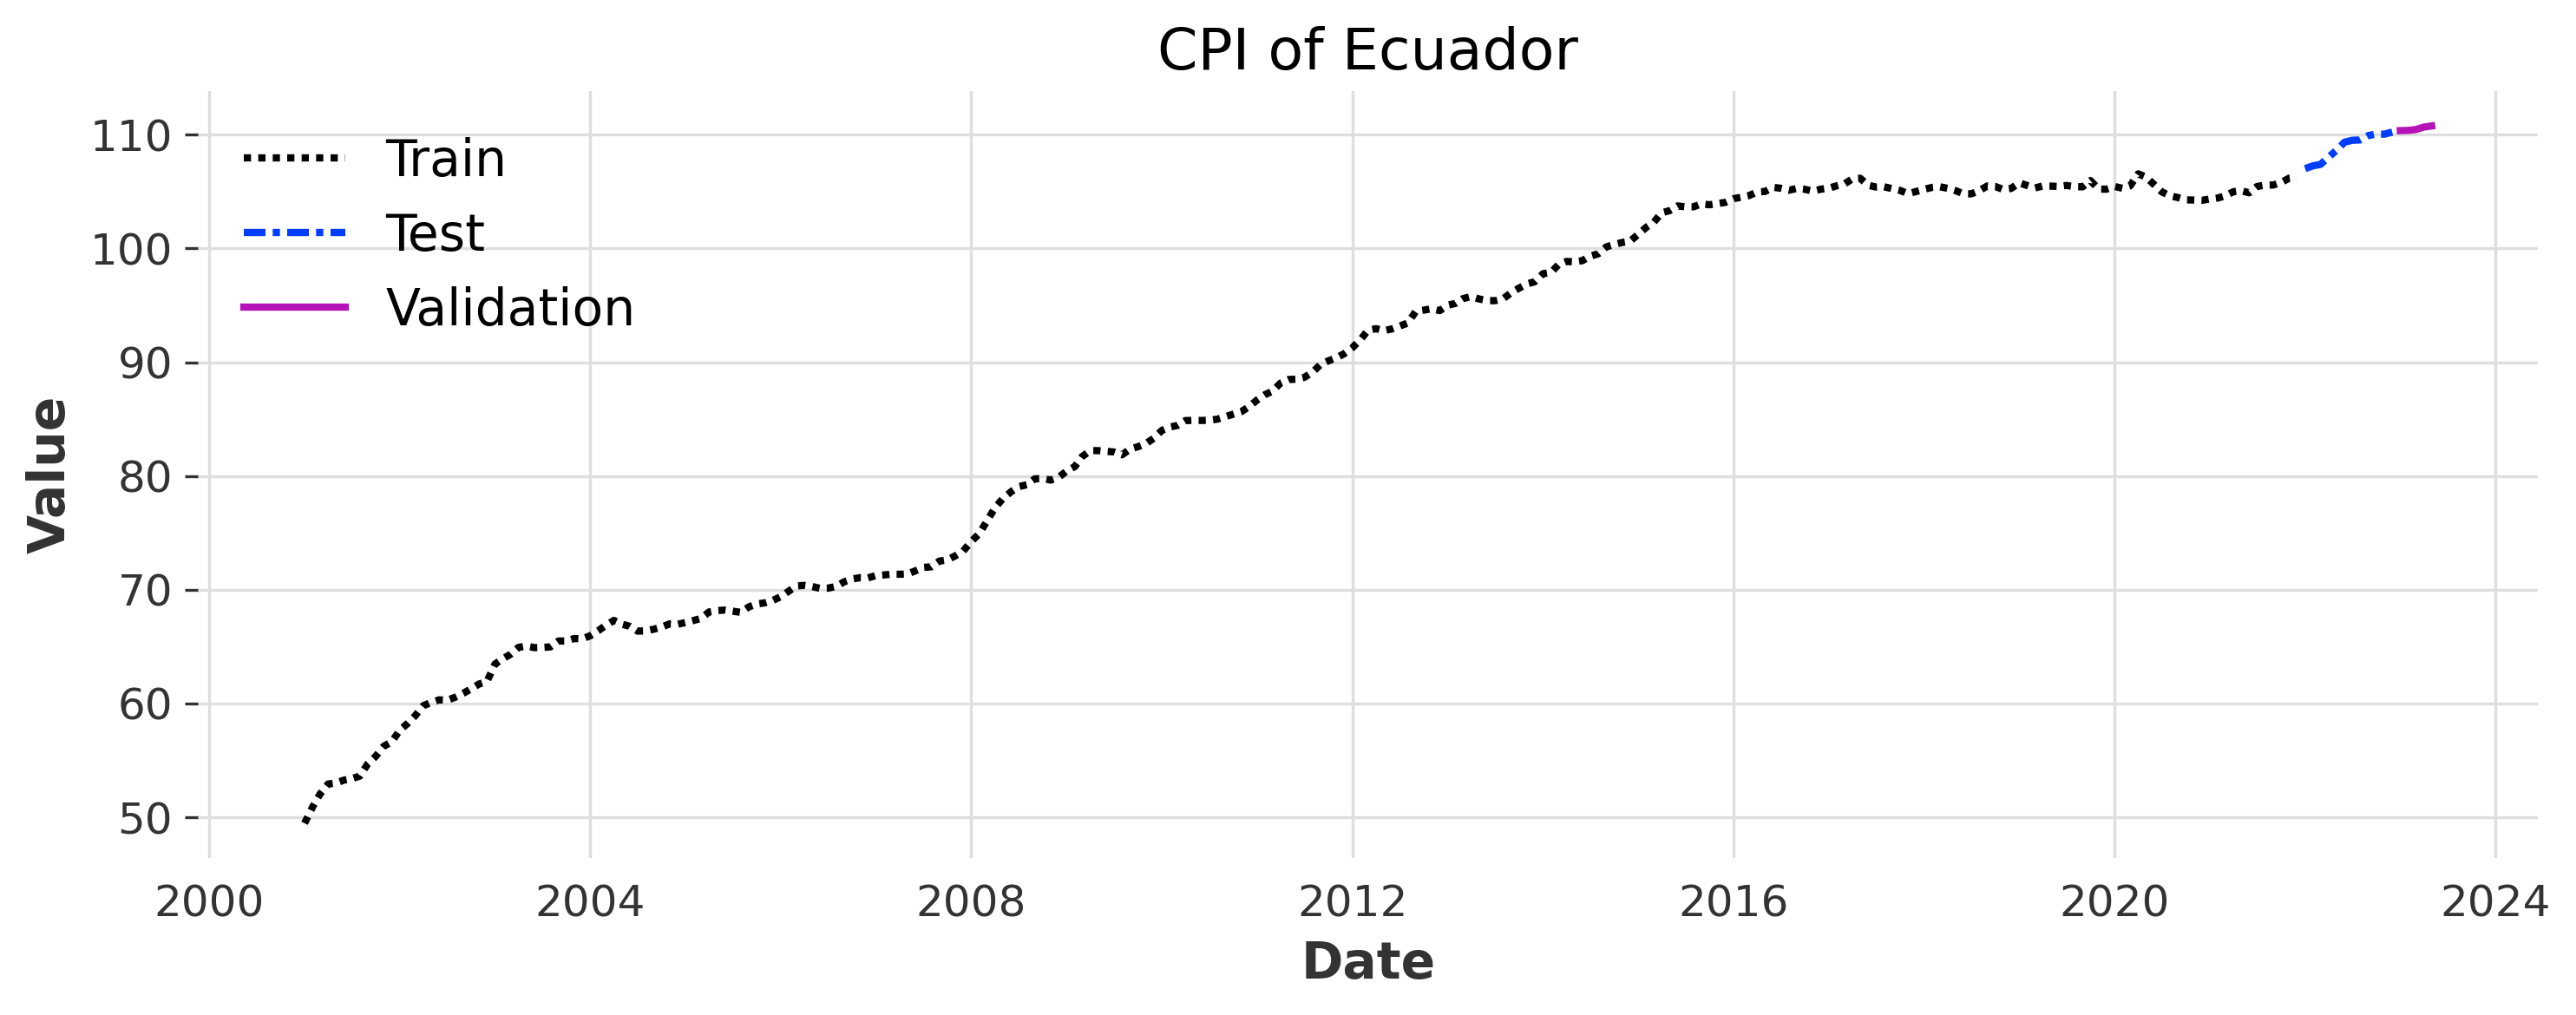

In [21]:
fs = 14
plt.figure(dpi=300, figsize=(10, 4), tight_layout=True)

plt.title('CPI of Ecuador',fontsize=fs+2)
plt.plot(cpi_serie[:-17],label='Train',linewidth=2,linestyle=(0,(1,1)))
plt.plot(cpi_serie[-17:-5],label='Test',linewidth=2,linestyle=(0,(3,1,1,1)))
plt.plot(cpi_serie[-5:],label='Validation',linewidth=2)
plt.xlabel('Date',fontsize=fs)
plt.ylabel('Value',fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.yticks(fontsize=fs-2)
plt.legend(fontsize=fs)
plt.savefig('../Figures/cpi_ec.png')

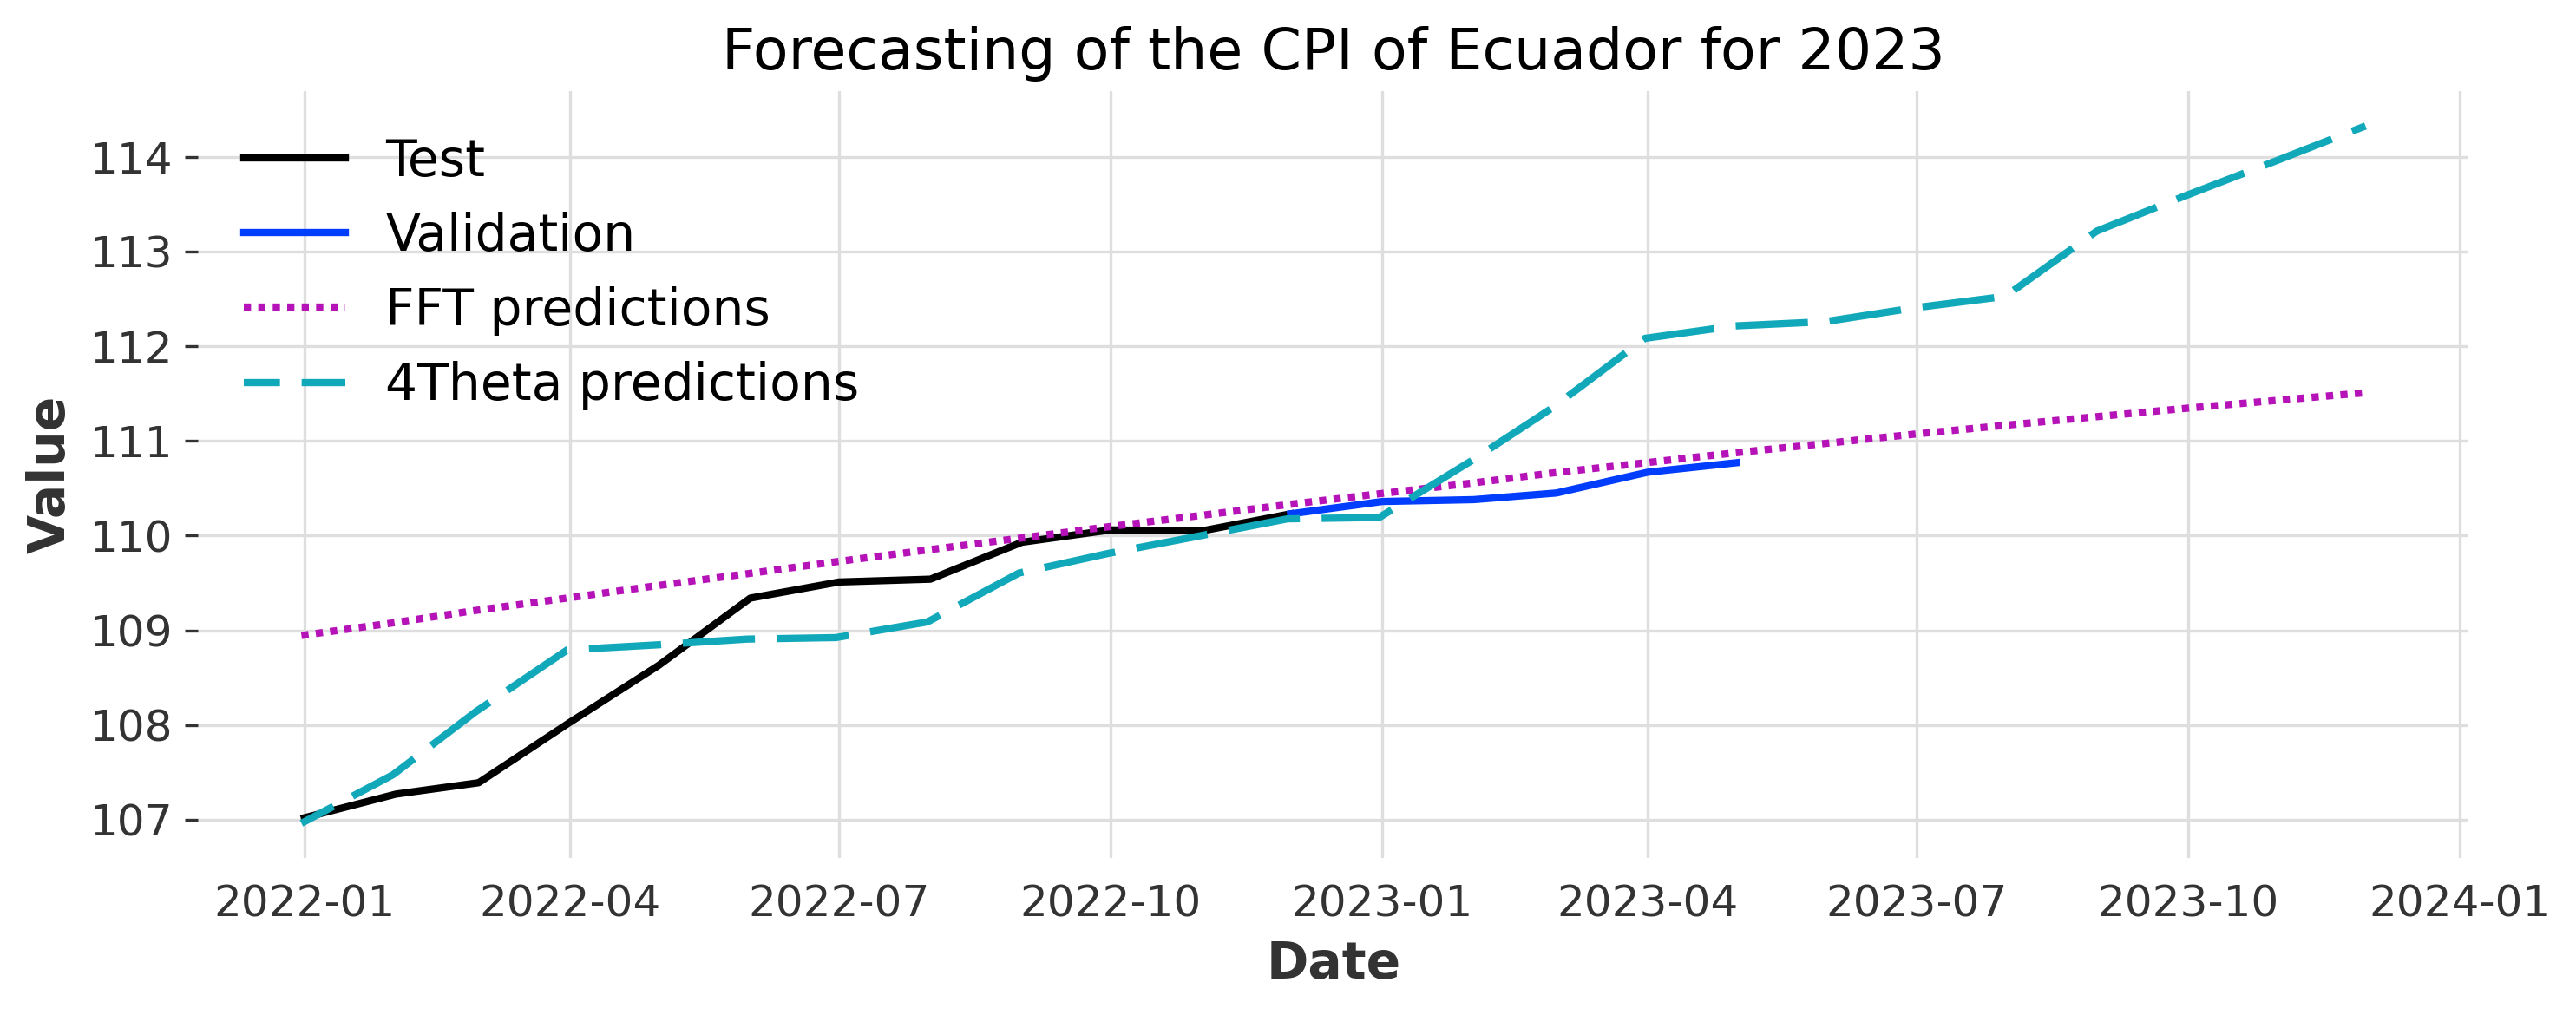

In [22]:
fs = 14
plt.figure(dpi=300, figsize=(10, 4), tight_layout=True)

plt.title("Forecasting of the CPI of Ecuador for 2023",fontsize=fs+2)
plt.plot(cpi_serie[-17:-5],label='Test',linewidth=2)
plt.plot(cpi_serie[-6:],label='Validation',linewidth=2)
plt.plot(pd.date_range(start='12/1/2021', periods=24,freq='M'),fp_FFT,label='FFT predictions',
         linewidth=2,linestyle=(0,(1,1)))
plt.plot(pd.date_range(start='12/1/2021', periods=24,freq='M'),fp_theta,label='4Theta predictions',
         linewidth=2,linestyle=(5,(10,3)))
plt.xlabel('Date',fontsize=fs)
plt.ylabel('Value',fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.yticks(fontsize=fs-2)
plt.legend(fontsize=fs)
plt.savefig('../Figures/cpi_ec_2023.png')